# **유통 판매량 예측 및 재고 최적화**

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

In [ ]:
import os

# 환경에 따라 path 설정
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'  # 코랩 경로
else:
    path = ''  # 로컬 경로

print(f'현재 작업 경로: {path}')

현재 작업 경로: 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional, LayerNormalization
from keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
data3 = pd.read_csv('data3.csv')

In [ ]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153 entries, 0 to 1152
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Qty                1153 non-null   float64
 1   CustomerCount      1153 non-null   float64
 2   WTI_Price          1153 non-null   float64
 3   Max_Temp           1153 non-null   float64
 4   Min_Temp           1153 non-null   float64
 5   Snow_Depth         1153 non-null   float64
 6   year               1153 non-null   int64  
 7   weekday            1153 non-null   int64  
 8   month              1153 non-null   int64  
 9   holiday            1153 non-null   int64  
 10  snowrain           1153 non-null   float64
 11  y                  1153 non-null   float64
 12  Qty_mean           1153 non-null   float64
 13  Qty_std            1153 non-null   float64
 14  Customer_mean      1153 non-null   float64
 15  CustomerCount_std  1153 non-null   float64
dtypes: float64(12), int64(4)

In [ ]:
data3

,Qty,CustomerCount,WTI_Price,Max_Temp,Min_Temp,Snow_Depth,year,weekday,month,holiday,snowrain,y,Qty_mean,Qty_std,Customer_mean,CustomerCount_std
0,9853.0,4422.0,95.140000,1.0,-8.0,6.0,2014,2,1,1,0.00,8647.0,8840.935484,3030.593121,4155.193548,525.890446
1,9853.0,4422.0,95.140000,4.0,-10.0,6.0,2014,3,1,0,0.00,15153.0,8840.935484,3030.593121,4155.193548,525.890446
2,8647.0,4167.0,93.660000,29.0,-10.0,6.0,2014,4,1,0,0.42,15606.0,8840.935484,3030.593121,4155.193548,525.890446
3,15153.0,5341.0,93.480000,35.0,-2.0,6.0,2014,5,1,1,0.02,7900.0,8840.935484,3030.593121,4155.193548,525.890446
4,15606.0,5123.0,93.300000,-2.0,-20.0,6.0,2014,6,1,1,0.00,7188.0,8840.935484,3030.593121,4155.193548,525.890446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,7856.0,3834.0,53.610000,59.0,37.0,0.0,2017,2,2,0,0.00,10208.0,10487.607143,3182.534144,4315.142857,590.958337
1149,8018.0,3955.0,54.480000,39.0,29.0,0.0,2017,3,2,0,0.00,12361.0,10487.607143,3182.534144,4315.142857,590.958337
1150,10208.0,4549.0,53.990000,29.0,20.0,0.0,2017,4,2,0,0.00,10108.0,10487.607143,3182.534144,4315.142857,590.958337
1151,12361.0,4619.0,54.006667,34.0,14.0,0.0,2017,5,2,1,0.00,10006.0,10487.607143,3182.534144,4315.142857,590.958337


# **2.모델링**


* 3차원 데이터 구조 만들기
    * timestep 수는 적절한 간격 설정
    
* LSTM, GRU 기반 초기 모델 생성

* 데이터 전처리 파이프라인 제작
    * input : raw data
    * output : x_train, x_val, y_train, y_val

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
categorical_columns = ['weekday','holiday']

for i in categorical_columns:
    data3[i] = pd.Categorical(data3[i])

data3 = pd.get_dummies(data3, columns = categorical_columns)

In [ ]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153 entries, 0 to 1152
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Qty                1153 non-null   float64
 1   CustomerCount      1153 non-null   float64
 2   WTI_Price          1153 non-null   float64
 3   Max_Temp           1153 non-null   float64
 4   Min_Temp           1153 non-null   float64
 5   Snow_Depth         1153 non-null   float64
 6   year               1153 non-null   int64  
 7   month              1153 non-null   int64  
 8   snowrain           1153 non-null   float64
 9   y                  1153 non-null   float64
 10  Qty_mean           1153 non-null   float64
 11  Qty_std            1153 non-null   float64
 12  Customer_mean      1153 non-null   float64
 13  CustomerCount_std  1153 non-null   float64
 14  weekday_0          1153 non-null   bool   
 15  weekday_1          1153 non-null   bool   
 16  weekday_2          1153 

In [ ]:
x = data3.drop(columns=['y'])
y = pd.DataFrame(data3.y)

In [ ]:
x_columns = list(x)
y_columns = list(y)

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y)

x = pd.DataFrame(x, columns=x_columns)
y = pd.DataFrame(y, columns=y_columns)
x

,Qty,CustomerCount,WTI_Price,Max_Temp,Min_Temp,Snow_Depth,year,month,snowrain,Qty_mean,...,CustomerCount_std,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_0,holiday_1
0,0.310284,0.326893,0.843322,0.119266,0.153061,0.25,0.0,0.000000,0.000000,0.563774,...,0.196971,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.310284,0.326893,0.843322,0.146789,0.132653,0.25,0.0,0.000000,0.000000,0.563774,...,0.196971,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.256826,0.283296,0.825220,0.376147,0.132653,0.25,0.0,0.000000,0.045113,0.563774,...,0.196971,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.545213,0.484014,0.823019,0.431193,0.214286,0.25,0.0,0.000000,0.002148,0.563774,...,0.196971,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.565293,0.446743,0.820817,0.091743,0.030612,0.25,0.0,0.000000,0.000000,0.563774,...,0.196971,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,0.221764,0.226363,0.335372,0.651376,0.612245,0.00,1.0,0.090909,0.000000,0.784199,...,0.279003,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1149,0.228945,0.247051,0.346013,0.467890,0.530612,0.00,1.0,0.090909,0.000000,0.784199,...,0.279003,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1150,0.326020,0.348607,0.340020,0.376147,0.438776,0.00,1.0,0.090909,0.000000,0.784199,...,0.279003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1151,0.421454,0.360574,0.340223,0.422018,0.377551,0.00,1.0,0.090909,0.000000,0.784199,...,0.279003,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
x3, y3 = temporalize(x, y, timesteps=4)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)
x_train.shape, x_val.shape

((1030, 4, 22), (120, 4, 22))

* **모델링**

In [ ]:
clear_session()

samples, time_steps, features = x_train.shape

model3_LSTM = Sequential([LSTM(units=128, return_sequences=True, input_shape=(time_steps, features)),
                          LayerNormalization(),
                          LSTM(units=64, return_sequences=True),
                          LayerNormalization(),
                          LSTM(units=32, return_sequences=True),
                          LayerNormalization(),
                          LSTM(units=16, return_sequences=False),
                          LayerNormalization(),
                          # Dense(8, activation='selu'),
                          # Dense(4, activation='selu'),
                          Dense(1)])
model3_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4, 128)              │          77,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 4, 128)              │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 4, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 4, 64)               │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 4, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 4, 32)               │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 16)                  │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,769 (557.69 KB)

 Trainable params: 142,769 (557.69 KB)

 Non-trainable params: 0 (0.00 B)

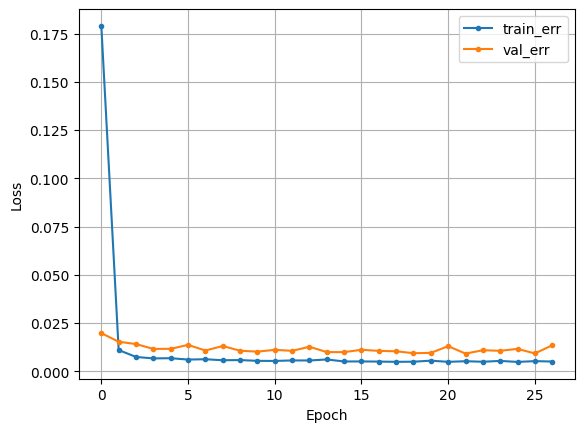

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model3_LSTM.compile(optimizer = 'adam', loss = 'mse')
hist = model3_LSTM.fit(x_train, y_train, epochs = 40, validation_data=(x_val, y_val), verbose = 0, callbacks=[es]).history
dl_history_plot(hist)

In [ ]:
pred = model3_LSTM.predict(x_val)
print(pred.shape)
print('MAE : ', mean_absolute_error(y_val, pred))
print('MAPE : ', mean_absolute_percentage_error(y_val, pred))
print('R2 : ', r2_score(y_val, pred))
#plot_model_result(y_train, y_val, pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 669ms/step
(120, 1)
MAE :  0.06606512117893139
MAPE :  0.1929165376225416
R2 :  0.6028101381667248


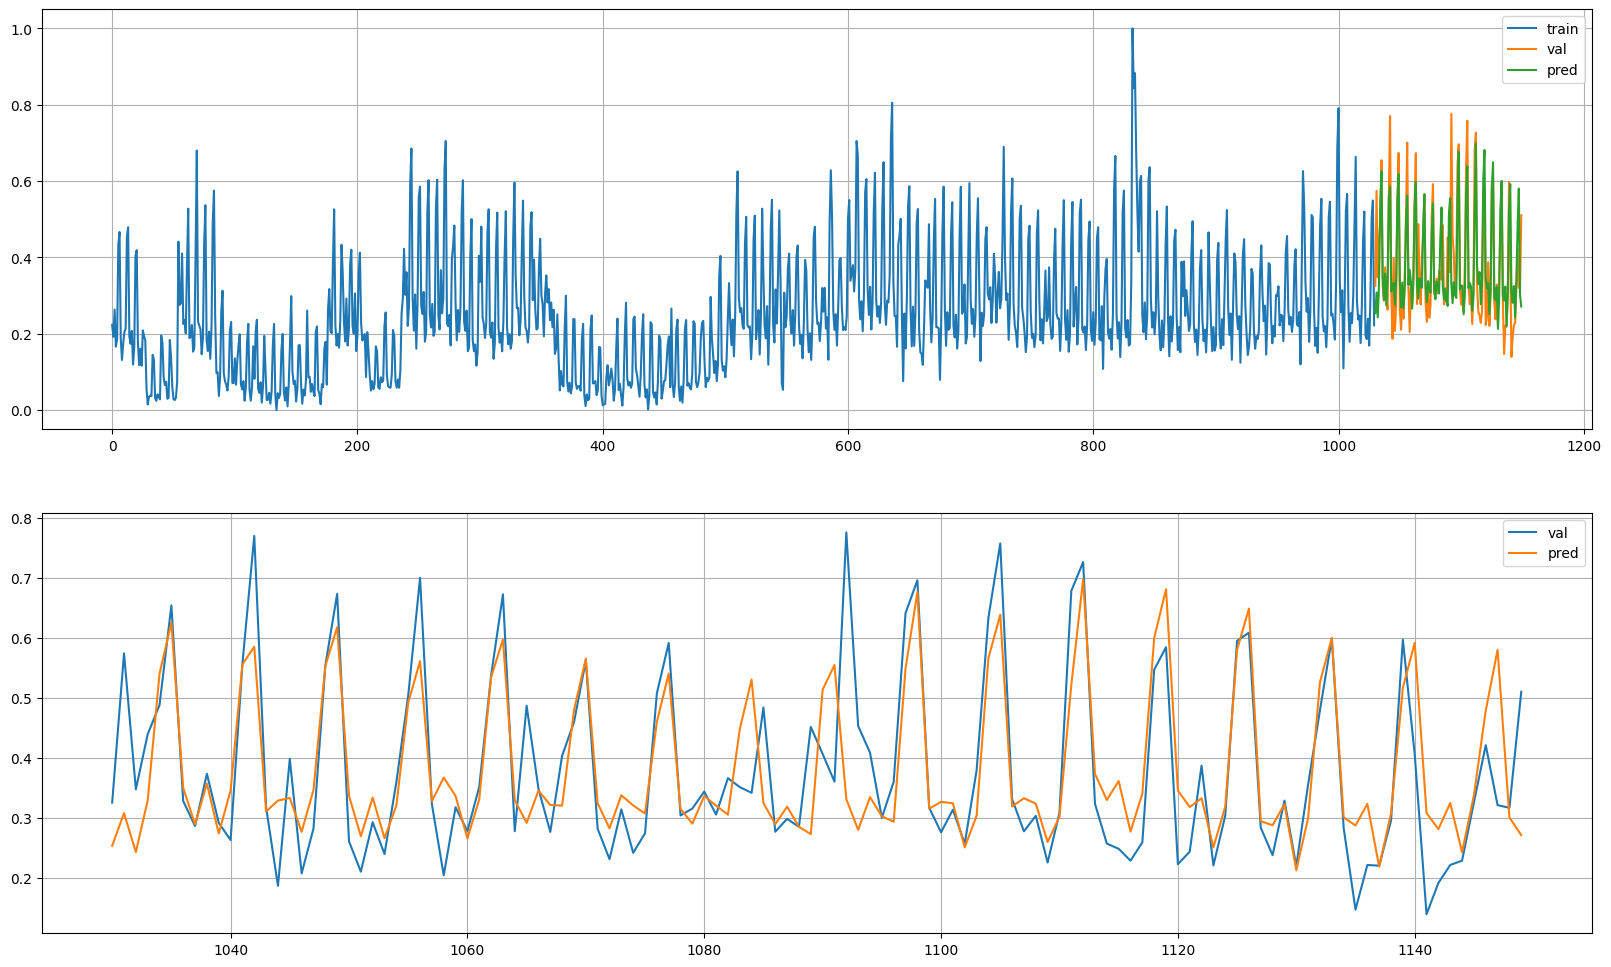

In [ ]:
plot_model_result(list(y_train), list(y_val), pred)

GRU 기반 모델링

In [ ]:
clear_session()

samples, time_steps, features = x_train.shape

model3_GRU = Sequential([GRU(units=128, return_sequences=True, input_shape=(time_steps, features)),
                          LayerNormalization(),
                          GRU(units=64, return_sequences=True),
                          LayerNormalization(),
                          GRU(units=32, return_sequences=True),
                          LayerNormalization(),
                          # GRU(units=64, return_sequences=False),
                          # LayerNormalization(),
                          GRU(units=16, return_sequences=False),
                          LayerNormalization(),
                          # Dense(8, activation='selu'),
                          # Dense(4, activation='selu'),
                          Dense(1)])
model3_GRU.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model3_GRU.compile(optimizer = 'adamW', loss = 'mse')
hist = model3_GRU.fit(x_train, y_train, epochs = 40, validation_data=(x_val, y_val), verbose = 1, callbacks=[es]).history
dl_history_plot(hist)

In [ ]:
pred = model3_GRU.predict(x_val)
print(pred.shape)
print('MAE : ', mean_absolute_error(y_val, pred))
print('MAPE : ', mean_absolute_percentage_error(y_val, pred))
print('R2 : ', r2_score(y_val, pred))

### **2) 상품 : 12 - Milk**

* **데이터 준비**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 64)               │          24,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,537 (146.63 KB)

 Trainable params: 37,537 (146.63 KB)

 Non-trainable params: 0 (0.00 B)

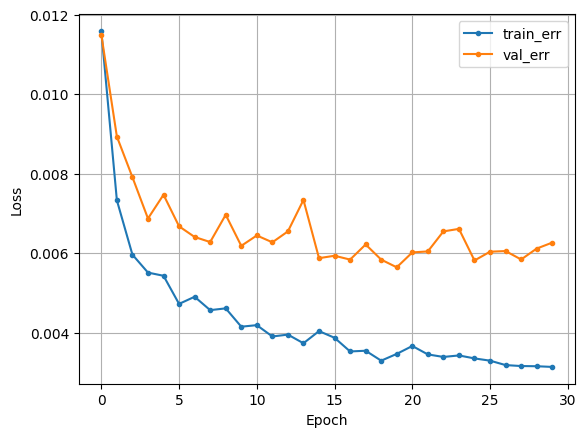

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
MAE :  1921.410770670573
MAPE :  5.917655143574143e+17
R2 :  0.458299237959655


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# 세션 초기화
clear_session()

_, ts, nfeat = x_train.shape

# 모델 아키텍처 개선
model12_02 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(ts, nfeat)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model12_02.summary()

# 컴파일
model12_02.compile(optimizer='adam', loss='mse')

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
hist = model12_02.fit(x_train, y_train, epochs=100, validation_split=0.2,
                       verbose=0, callbacks=[early_stopping]).history

dl_history_plot(hist)

# 평가
pred = model12_02.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ', mean_absolute_percentage_error(y_val2, pred))
print('R2 : ', r2_score(y_val2, pred))

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
def preproc3d(data, timesteps, target="12_shifted", y_scale = False) :
    drop_columns = [target]
    if "Date" in data.columns:
      drop_columns.append("Date")

    data = data.dropna()
    x = data.drop(drop_columns, axis = 1)
    y = data.loc[:, target]

    # 가변수화
    try:
      x['Weekday'] = pd.Categorical(x['Weekday'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
      x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
      x = pd.get_dummies(x, columns = ['Weekday','Month'])
    except:
      pass

    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [ ]:
###데이터 준비
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data_42, timesteps, target="Target_Qty", y_scale=True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1027, 7, 11), (120, 7, 11))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model42_LSTM = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model42_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261 (1.02 KB)

 Trainable params: 261 (1.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model42_LSTM.compile(optimizer = 'adam', loss = 'mse')
hist = model42_LSTM.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [ ]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')
weather_test = pd.read_csv(path + 'test/weather_test.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )
weather_test['Date'] = pd.to_datetime(weather_test['Date'])

In [ ]:
def preprocessing4predict(sales, orders, weather, oil_price, Store_ID = 44, product_ID = 3, categorical_columns = ['weekday', 'holiday'],
                         x_scaler=x_scaler, y_scaler=y_scaler, timesteps=4):

    sales = sales[(sales.Store_ID == Store_ID) & (sales.Product_ID == product_ID)]
    orders = orders[orders.Store_ID == Store_ID]
    data = pd.merge(sales, orders, how='left', on=['Date', 'Store_ID'])
    data = pd.merge(data, oil_price, how='left', on=['Date'])
    data = pd.merge(data, weather, how='left', on=['Date'])

    data['year'] = data['Date'].dt.year
    data['weekday'] = data['Date'].dt.weekday
    data['month'] = data['Date'].dt.month

    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays()

    data['holiday'] = np.where((data['weekday'] >= 5) | (data['Date'].isin(holidays)), 1, 0)

    data['snowrain'] = data['Precipitation (inches)'] + data['Snow (inches)']
    data.drop(columns=['Store_ID', 'Product_ID', 'Precipitation (inches)', 'Snow (inches)'], inplace=True)
    data.rename(columns={"Maximum Temperature degrees (F)": "Max_Temp", "Minimum Temperature degrees (F)": "Min_Temp"}, inplace=True)

    Qty_stats = data.groupby(by=['year', 'month'], as_index=False)['Qty'].agg(['mean', 'std'])
    CustomerCount_stats = data.groupby(by=['year', 'month'], as_index=False)['CustomerCount'].agg(['mean', 'std'])

    data = pd.merge(data, Qty_stats, how='left', on=['year', 'month'])
    data = pd.merge(data, CustomerCount_stats, how='left', on=['year', 'month'])
    data.rename(columns={"mean_x": "Qty_mean", "std_x": "Qty_std", "mean_y": "Customer_mean", "std_y": "CustomerCount_std"}, inplace=True)

    data.rename(columns={"Snow Depth (inches)": "Snow_Depth"}, inplace=True)
    data.drop(columns='Date', inplace=True)

    data['y'] = data['Qty'].shift(-2)
    data = data.iloc[:len(sales_test)-2]

    for i in categorical_columns:
        data[i] = pd.Categorical(data[i])

    data['WTI_Price'] = data['WTI_Price'].interpolate(method='linear')
    data = pd.get_dummies(data, columns = categorical_columns)

    x_test = data.drop(columns='y')
    y_test = pd.DataFrame(data3.y)

    x_columns = list(x_test)
    y_columns = list(y_test)

    x_test = x_scaler.transform(x_test)
    y_test = y_scaler.transform(y_test)

    x_test = pd.DataFrame(x_test, columns=x_columns)
    y_test = pd.DataFrame(y_test, columns=y_columns)

    x_test, y_test = temporalize(x_test, y_test, timesteps)

    return x_test, y_test

x_test, y_test = preprocessing4predict(sales_test, orders_test, weather_test, oil_price_test)
x_test.shape, y_test.shape

((28, 4, 22), (28, 1))

In [ ]:
x_test, y_test = preprocessing4predict(sales_test, orders_test, weather_test, oil_price_test)

In [ ]:
x_test.shape, y_test.shape

((28, 4, 22), (28, 1))

* 예측해보기

In [ ]:
y_origin = y_scaler.inverse_transform(y_test)
pred = model3_LSTM.predict(x_test)
y_pred_origin = y_scaler.inverse_transform(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [ ]:
pred

array([[0.31219605],
       [0.30840084],
       [0.31361514],
       [0.22751519],
       [0.31607294],
       [0.5427273 ],
       [0.6054743 ],
       [0.3260132 ],
       [0.31478643],
       [0.31750593],
       [0.21968862],
       [0.3081436 ],
       [0.54825974],
       [0.6133812 ],
       [0.31807926],
       [0.31497216],
       [0.32520095],
       [0.23081651],
       [0.3244413 ],
       [0.55423605],
       [0.6140569 ],
       [0.3263942 ],
       [0.31950215],
       [0.33080453],
       [0.23290613],
       [0.3225908 ],
       [0.55562156],
       [0.6048829 ]], dtype=float32)

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수, 필요하다면 해당 함수를 수정해서 사용
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [ ]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [ ]:
inv_simulator(y_origin, y_pred_origin, 20, 8)

일평균 재고량     : 6815.981
일평균 재고 금액  : 54527.848
일평균 재고회전율 : 1.333
기회손실 수량     : -1178.0


,y,pred,base_stock,close_stock,order,receive,lost
0,7900.0,9896.0,7920,20,9928,7900,0.0
1,7188.0,9811.0,7208,20,7986,7188,0.0
2,8800.0,9928.0,9948,1148,8856,9928,0.0
3,6606.0,7986.0,9134,2528,12589,7986,0.0
4,7051.0,9984.0,11384,4333,12199,8856,0.0
5,12599.0,15097.0,16922,4323,5905,12589,0.0
6,13383.0,16512.0,16522,3139,6836,12199,0.0
7,7086.0,10208.0,9044,1958,8078,5905,0.0
8,5821.0,9955.0,8794,2973,4856,6836,0.0
9,6815.0,10016.0,11051,4236,5589,8078,0.0
